# Does negativity make success?

In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from collections import Counter
from helpers import text_from_ids, neg_words
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import nltk
from nltk.stem import *
import re 
import gensim
import pickle 
import operator
import pyLDAvis
import pyLDAvis.gensim_models
import tqdm

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Install missing libraries (uncomment lines to install)
#!pip install wordcloud
#!pip install pyldavis
#!pip install --upgrade gensim
#nltk.download('wordnet')
#!pip install jupyter_dash

#### Load the dataframe containing videos from 2019 and their features

This is a big file (860 MB) so we have stored it on Google Drive. Download it from the link below and storie it as `generated/2019/2019_videos_Typo_Emojis_NegWords_Sentiment_title_desc.parquet`. It was generated by the notebook `data_processing.ipynb`.

https://drive.google.com/file/d/1RmVSw2MBq0Ps0dwcTQjqZsDAuivXbUaZ/view?usp=share_link

In [ ]:
filepath = 'generated/2019/2019_videos_Typo_Emojis_NegWords_Sentiment_title_desc.parquet'
videos = pd.read_parquet(filepath, engine='fastparquet')

In [ ]:
videos.head()

## What is negativity?

### Small intro (examples with sia from vader)

In [ ]:
sia = SentimentIntensityAnalyzer()

sentences = [
    'You will never be a great YouTuber! You are lazy!',
    'We will bring so much you fame and success! You are great!',
    'We might or might not be able to help you.'
]

for sentence in sentences:
    print('Sentence:')
    print(sentence)
    print('Vader sentiment analysis:')
    print(sia.polarity_scores(sentence))
    print('')

# Is there something to investigate ?

The trending videos dataset is used to determine a treshold on views and likes to split our dataset in two: Successful and not successful videos.

In [ ]:
#Loading of the trending datasets (US trending videos from 2018) [[put correct link/year]]
df_trends = pd.read_csv('data/additionnal/US_youtube_trending_data.csv')
df_trends

In [ ]:
#Determination of the tresholds
treshold_views = np.quantile(df_trends['view_count'], 0.4)
treshold_likes = np.quantile(df_trends['likes'], 0.4)

In [ ]:
#Dataset of the successful videos
videos_success = videos.loc[(videos['view_count'] > treshold_views)]
videos_success = videos_success.loc[(videos_success['like_count'] > treshold_likes)]

In [ ]:
#Dataset of the not successful videos
new_videos = videos.drop(videos_success.index)

The two dataset need to be modified in order to plot the comparison

In [ ]:
sia_neg_title_success = videos_success[['sia_negative_title', 'categories']]
sia_neg_description_success = videos_success[['sia_negative_description', 'categories']]


sia_neg_title = new_videos[['sia_negative_title', 'categories']]
sia_neg_description = new_videos[['sia_negative_description', 'categories']]

Construction of the negative title success dataset

In [ ]:
neg_title_suc = ['Negative sentiment in title']
sia_bool_neg_title_suc = ['successful']

neg_title_suc = neg_title_suc*len(sia_neg_title_success)
sia_bool_neg_title_suc = sia_bool_neg_title_suc*len(sia_neg_title_success)
neg_title_suc_cat = sia_neg_title_success['categories']
sia_neg_title_success = sia_neg_title_success['sia_negative_title']

In [ ]:
sia_neg_title_success_values = sia_neg_title_success.values
sia_neg_title_success = sia_neg_title_success_values.tolist()

In [ ]:
#Creation of the negative title success dataset
data_given = {'Type of sentiment': neg_title_suc, 'SIA value': sia_neg_title_success, "Video's success": sia_bool_neg_title_suc, 'categories':neg_title_suc_cat}

neg_title_suc_df = pd.DataFrame(data = data_given)

Construction of the negative title not success dataset

In [ ]:
neg_title = ['Negative sentiment in title']
sia_bool_neg_title = ['not successful']

neg_title = neg_title*len(sia_neg_title)
sia_bool_neg_title = sia_bool_neg_title*len(sia_neg_title)
neg_title_cat = sia_neg_title['categories']
sia_neg_title = sia_neg_title['sia_negative_title']

In [ ]:
sia_neg_title_values = sia_neg_title.values
sia_neg_title = sia_neg_title_values.tolist()


In [ ]:
#Creation of the negative title success dataset
data_given = {'Type of sentiment': neg_title, 'SIA value': sia_neg_title, "Video's success": sia_bool_neg_title, 'categories':neg_title_cat}

neg_title_df = pd.DataFrame(data = data_given)



In [ ]:
#Total dataset for the title (merge success and not)
neg_title_total_df = neg_title_suc_df.append(neg_title_df, ignore_index=True)

Construction of the negative description success dataset

In [ ]:
neg_description_suc = ['Negative sentiment in description']
sia_bool_neg_description_suc = ['successful']

neg_description_suc = neg_description_suc*len(sia_neg_description_success)
sia_bool_neg_description_suc = sia_bool_neg_description_suc*len(sia_neg_description_success)
neg_description_suc_cat = sia_neg_description_success['categories']
sia_neg_description_success = sia_neg_description_success['sia_negative_description']

In [ ]:
sia_neg_description_success_values = sia_neg_description_success.values
sia_neg_description_success = sia_neg_description_success_values.tolist()

In [ ]:
#Creation of the negative description success dataset
data_given = {'Type of sentiment': neg_description_suc, 'SIA value': sia_neg_description_success, "Video's success": sia_bool_neg_description_suc, 'categories':neg_description_suc_cat}

neg_description_suc_df = pd.DataFrame(data = data_given)


Construction of the negative description not success dataset

In [ ]:
neg_description = ['Negative sentiment in description']
sia_bool_neg_description = ['not successful']

neg_description = neg_description*len(sia_neg_description)
sia_bool_neg_description = sia_bool_neg_description*len(sia_neg_description)



In [ ]:
neg_description_cat = sia_neg_description['categories']
sia_neg_description = sia_neg_description['sia_negative_description']

In [ ]:
sia_neg_description_values = sia_neg_description.values
sia_neg_description = sia_neg_description_values.tolist()

In [ ]:
#Creation of the negative description not success dataset
data_given = {'Type of sentiment': neg_description, 'SIA value': sia_neg_description, "Video's success": sia_bool_neg_description, 'categories':neg_description_cat}

neg_description_df = pd.DataFrame(data = data_given)


#Total dataset for the description (merge success and not)
neg_description_total_df = neg_description_suc_df.append(neg_description_df, ignore_index=True)

#Creation of the complete dataset to be plot
neg_total_df = neg_title_total_df.append(neg_description_total_df, ignore_index=True)


In [ ]:
sns.barplot(
    data=neg_total_df, 
    x="Type of sentiment", 
    y="SIA value", 
    hue="Video's success", 
    color='blue', 
    palette='hls',
    n_boot=100
)
plt.title("Negative sentiment intensity in successful vs. not successful videos")
plt.show()

## Regression analysis

### Overall

try description and title (look at R to find what is best) [[Djian: description is better]]

In [ ]:
def print_regression(data, formula):
    model = smf.ols(formula=formula, data=data)
    np.random.seed(2)
    results = model.fit()
    print(results.summary())

In [ ]:
# Remove videos where 'like_count' is NaN
videos = videos[videos['like_count'].isna() == False]

# Convert some rows to float
videos['like_count'] = videos['like_count'].astype(float)
videos['dislike_count'] = videos['dislike_count'].astype(float)
videos['view_count'] = videos['view_count'].astype(float)

# New columns for the log of the counts (+1 so that the log is always defined)
videos['log_view_count'] = np.log(videos['view_count'] + 1)
videos['log_like_count'] = np.log(videos['like_count'] + 1)
videos['log_dislike_count'] = np.log(videos['dislike_count'] + 1)

In [ ]:
success_factors = ['log_view_count', 'log_like_count', 'log_dislike_count']


def regression_formula(success_factor):
    f = f'{success_factor} ~ '
    f += 'sia_negative_description ' 
    f += '+ sia_positive_description '
    f += '+ sia_neutral_description '
    return f


formulas = [regression_formula(s) for s in success_factors]

for f in formulas:
    print(f'Regression analysis for formula \n{f}')
    print_regression(data=videos, formula=f)
    print('')
    print('')

### By category

In [ ]:
# Find the categories
categories = set(videos['categories'].values)
categories.remove(None)

In [ ]:
regression_for_success_factor = dict()

for success_factor in success_factors:
    f = regression_formula(success_factor)
    
    results_params_f = dict()

    for category in categories:
        videos_category = videos[videos['categories'] == category]
        model = smf.ols(formula=f, data=videos_category)
        np.random.seed(2)
        results = model.fit()
        results_params_f[category] = pd.concat([results.params, results.pvalues], keys=['parameter', 'p-value'])

    df_regression = pd.DataFrame(results_params_f).transpose()
    
    regression_for_success_factor[success_factor] = df_regression

In [ ]:
# Look at the p-values to check the statistical significance of the parameters
for name, df_reg in regression_for_success_factor.items():
    pvalues = df_reg['p-value']
    
    print(f'P-values for the regression parametersfor {name}')
    print(pvalues.max())
    

**Result**. The regressions log_like_count and log_dislike_count are fine, but we should investigate more closely log_view_count.

In [ ]:
regression_for_success_factor['log_view_count']['p-value']

**Result.** The only coefficient with a p-value larger than 0.05 is sia_positive_description for the category Film & Animation. So this parameter is not statistically significant.

In [ ]:
def plot_regression(df_regression, name=''):
    
    df_reg = df_regression.copy()
    
    # Drop p-values and `Intercept`, remove index
    df_reg = df_reg['parameter']
    df_reg = df_reg.drop('Intercept', axis=1)
    df_reg = df_reg.reset_index()

    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.scatter(x=df_reg['index'], y=df_reg['sia_negative_description'], label='negative', marker='$:($', color='crimson', s=50)
    plt.scatter(x=df_reg['index'], y=df_reg['sia_neutral_description'], label='neutral',  marker='$:|$', color='gray', s=50)
    plt.scatter(x=df_reg['index'], y=df_reg['sia_positive_description'], label='positive',  marker='$:)$', color='dodgerblue', s=50)
    plt.xticks(rotation=90)
    plt.title(f'Coefficients in the linear regression for {name}, by video category')
    plt.ylabel('log_count')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'generated/plots/regression_{name}') # Save the plot to png
    plt.show()

In [ ]:
# Plot the regression parameters for various success factors
for success_f in success_factors:
    plot_regression(regression_for_success_factor[success_f], name=success_f)

In [ ]:
# Conclusion: categories with sia_negative large compared to sia_neutral (in the linear regression for log_view_count)
interesting_cats = {
    'Entertainment', 'Film & Animation', 'Education', 
    'Autos & Vehicles', 'Howto & Style', 'Music', 
    'Pets & Animals', 'Science & Technology', 'Sports',
    'Travel & Events'
}

Creation of the interactive plot for the log view count depending on the sia

In [ ]:
df_reg = regression_for_success_factor['log_view_count'].copy()
    
# Drop p-values and `Intercept`, remove index
df_reg = df_reg['parameter']
df_reg = df_reg.drop('Intercept', axis=1)
df_reg = df_reg.reset_index()



In [ ]:
from jupyter_dash import JupyterDash
import dash_html_components as html
import dash_core_components as dcc
import plotly.graph_objs as go
import plotly.express as px
import dash
import math
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

In [ ]:
app = JupyterDash(__name__)


app.layout = html.Div([
    html.H4('Difference in the SIA value in the title depending on the success of the video'),
    dcc.Dropdown(
        id="dropdown",
        options=['People & Blogs', 'Science & Technology', 'Gaming',
       'Film & Animation', 'News & Politics', 'Howto & Style', 'Music',
       'Entertainment', 'Education', 'Comedy', 'Travel & Events',
       'Sports', 'Autos & Vehicles', 'Pets & Animals',
       'Nonprofits & Activism'],
        value="People & Blogs",
        clearable=False,
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"), 
    Input("dropdown", "value"))
def update_bar_chart(cat):
    df = df_reg # replace with your own data source
    
    mask = df["index"] == cat
    
    inter = df_reg[mask]
    inter_dic = {'Sentiment': ['sia_negative_description', 'sia_positive_description', 'sia_neutral_description'], 'Value': [inter['sia_negative_description'].values[0], inter['sia_positive_description'].values[0], inter['sia_neutral_description'].values[0]]}
    inter_df = pd.DataFrame(data= inter_dic)

    fig = px.bar(inter_df, x="Sentiment", y="Value", barmode='group')
    return fig


app.run_server(debug = True,port=8050)

## What does successful negativity look like?

### Most used words: the vocabulary of videos that are negative and successful (for different categories) [[Maj]]

Make 'histogram' of words in title/desc for videos that are very negative and have lots of success (maybe do it for each category). Example:

https://ldrame21.github.io/metoo-media-impact/#data-story-title

#### What is a negative and successful video?

Negative videos are the ones in the top 1% most negative videos according to sia_negative_description. 

Successful videos are the ones in the top 30% videos according to the number of views.

In [ ]:
df_videos = videos.copy()
df_videos.shape

In [ ]:
# Whats the minimum number of views among successful videos?
lower_bound_success = df_videos['view_count'].quantile(0.7)
print(f'Successful videos have >= {lower_bound_success} views.')

# Whats the minimum sia_negative_description value among negative videos?
lower_bound_sia = df_videos['sia_negative_description'].quantile(0.99)
print(f'Negative videos have sia_negative_description >= {lower_bound_sia}.')

# Select negative and successful videos
df_filtered = df_videos[(df_videos['sia_negative_description'] >= lower_bound_sia) & (df_videos['view_count'] >= lower_bound_success)]
print(f'We have {len(df_filtered)} videos that are both successful and negative.')

In [ ]:
# Retrieve the tags, titles and descriptions of the videos we have filtered
data_path = 'generated/2019/2019_videos.csv'
video_ids = set(df_filtered['display_id'])
df_title_des = text_from_ids(video_ids, data_path) #contains display_id, title, description and tags

In [ ]:
df_title_des.head

In [ ]:
# Merge both dataframes
df_combined = pd.merge(df_filtered, df_title_des, on="display_id")
df_combined.head

### Wordclouds

In [ ]:
# Name of the video text field that we will use for the wordclouds ('title', 'tags' or 'description')
field_to_analyze = 'title' 

# remove stopwords from the text field 
def remove_stopwords(df):
    df_cleaned = df.copy()
    df_cleaned['tokens'] = df_cleaned[field_to_analyze].apply(lambda title: title.split())
    stop_words = stopwords.words('english') + ['|', '_', '-', ',', '.', '!', '?', '&', ':'] # also remove some punctuation
    df_cleaned['tokens'] = df_cleaned['tokens'].apply(
        lambda tokens: [token for token in tokens if token.lower() not in stop_words]
    )
    return df_cleaned

df_cleaned = remove_stopwords(df_combined)
df_cleaned.head()

In [ ]:
# Select the 5 most successful categories based on view_count (we do not use it anymore)
'''grouped = df_cleaned.groupby("categories")
most_successful = {}
for name, group in grouped:
    most_successful[name] = group['view_count'].mean()
sorted_dict = sorted(most_successful.items(), key=operator.itemgetter(1), reverse=True)[:5]
print(sorted_dict)'''

In [ ]:
# Find the most common words 
common_words_with_freq = {}

categorie_groups = df_cleaned.groupby("categories")
for name, group in categorie_groups:
    flattened = [val for sublist in group['tokens'].tolist() for val in sublist]
    common_words_with_freq[name] = Counter(flattened).most_common(100)
#convert the dict to a dataframe   
L = [(k, *t) for k, v in common_words_with_freq.items() for t in v]
df_success = pd.DataFrame(L, columns=['categories','common_words','frequency'])
df_success

In [ ]:
df_success_all = pd.DataFrame(common_words_with_freq.items(), columns=['categories', 'most_common_words'])
df_success_all

In [ ]:
grouped = df_success.groupby("categories")
for name, group in grouped:
    group_words = [item.lower() for item in grouped['common_words'].get_group(name).tolist()]
    #group_neg_words = list(set(group_words) & neg_set)
    if(len(group_words) != 0):
        # Only do the wordclouds for interesting categories, that were determined manually by looking at the wordclouds
        if name in {'Entertainment', 'Education', 'Howto & Style', 'Pets & Animals'}: 
            group_freq = grouped['frequency'].get_group(name).tolist()
            data = dict(zip(group_words, group_freq))
            
            # Generate the wordcloud
            wc = WordCloud(
                width=800, 
                height=400, 
                max_words=250, 
                background_color='white', 
                random_state=3, # Use random_state=3 as a random seed, for reproducibilty of the results
                #colormap='ocean',
                mode='RGBA'
            ).generate_from_frequencies(data)
            
            # Save the wordcloud to a file
            filename = name.replace(' ', '_').replace('&', 'and') # Remove whitespaces and ampersands
            wc.to_file(f'generated/wordclouds/wc_{filename}.png')

            # Display the wordcloud
            plt.figure(figsize=(12, 8))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.title(name)
            plt.show()       

## What topics appear the most in negative and successful videos? 

In [ ]:
# Name of the video text field that we will use for the wordclouds ('title', 'tags' or 'description')
field_to_analyze = 'description' 
 
def remove_stopwords(df):
    df_cleaned = df.copy()
    df_cleaned['tokens'] = df_cleaned[field_to_analyze].apply(lambda title: title.split())
    stop_words = stopwords.words('english')
    df_cleaned['tokens'] = df_cleaned['tokens'].apply(lambda tokens: [token for token in tokens if token.lower() not in stop_words])
    return df_cleaned

df_cleaned_lda = remove_stopwords(df_combined)

In [ ]:
# [[Dont forget the put the reference]]

In [ ]:
# Category of videos where we will do topic extraction [[Djian: What category to choose? Or do the analysis for all categories together?]]
#category_for_lda = 'Education'
#category_for_lda = 'Entertainment'
category_for_lda = 'Pets & Animals'
#category_for_lda = 'Howto & Style'
#category_for_lda = 'Travel & Events'

In [ ]:
stopwords_set = set(stopwords.words('english'))

In [ ]:
df_topics = df_cleaned_lda[df_cleaned_lda['categories'] == category_for_lda]

In [ ]:
def remove_url_and_tags(text):
    text = re.sub(r'https?:\S*','',text)
    return re.sub(r'@\S*','',text)
df_topics.description = df_topics.description.apply(remove_url_and_tags)

In [ ]:
def preprocessing(df):
    lemmatizer = WordNetLemmatizer() # For Lemmatization
    lem_words = []
    for text in df['description']:
        words=[w for w in nltk.tokenize.word_tokenize(text) if (w not in stopwords_set)]
        words=[lemmatizer.lemmatize(w) for w in words if len(w)>2]
        lem_words.append(words)
    return lem_words

words = preprocessing(df_topics)

In [ ]:
# Transform to gensim dictionary
id2word = gensim.corpora.Dictionary(words) 
bows = [id2word.doc2bow(doc) for doc in words]
#pickle.dump(bows, open('corpus.pkl', 'wb'))
id2word.save('dictionary.gensim')

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=bows, num_topics=15, id2word=id2word, passes=10, workers=1, random_state=6)
lda_model.save('model15.gensim')

In [ ]:
# We print words occuring in each of the topics as we iterate through them
#for idx, topic in lda_model.print_topics(num_words=50):    
#    print('Topic: {} \nWords: {}'.format(idx, topic))

### Visualizing results

In [ ]:
# Loading the dictionary and corpus files we already saved
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))

# Loading the model of 15 categories we already saved
lda_model = gensim.models.ldamodel.LdaModel.load('model15.gensim')
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bows, id2word, sort_topics=False)

# Export to HTML
pyLDAvis.save_html(data=vis, fileobj='generated/topics.html')

# Display
pyLDAvis.display(vis)

# Evolution of channels when posting negative content

In this part, we will try to plot the evolution of channels when posting negative content. The goal is to determine visually a correlation between the negativity of the title and description with the delta of views, subs, likes and dislikes, i.e will posting a video with a negative title impact the success over time ?

In [3]:
df_timeseries = pd.read_csv("data/df_timeseries_en.tsv", sep="\t")
df_timeseries_2019 = df_timeseries[pd.to_datetime(df_timeseries["datetime"]).dt.year == 2019]
filepath = 'generated/2019/2019_videos_Typo_Emojis_NegWords_Sentiment_title_desc.parquet'
videos = pd.read_parquet(filepath, engine='fastparquet')

We firstly want to merge each video with the corresponding timeserie, to have access to the channel current state at time of upload, such as the delta_subs and delta_views. Since the timeseries might not have been snapshotted at the exact same date as the upload date, we will merge "asof", i.e on the closest date.

In [4]:
df_timeseries_2019["datetime"] = pd.to_datetime(df_timeseries_2019['datetime'])
df_timeseries_2019.rename({"datetime": "nearest_time"}, axis=1, inplace=True)
videos.rename({"upload_date": "nearest_time"}, axis=1, inplace=True)
df_timeseries_2019.rename({"channel": "channel_id"}, axis=1, inplace=True)

C:\Users\Victor\AppData\Local\Temp\ipykernel_19156\1391806633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_timeseries_2019["datetime"] = pd.to_datetime(df_timeseries_2019['datetime'])
C:\Users\Victor\AppData\Local\Temp\ipykernel_19156\1391806633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_timeseries_2019.rename({"datetime": "nearest_time"}, axis=1, inplace=True)
C:\Users\Victor\AppData\Local\Temp\ipykernel_19156\1391806633.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

In [5]:
videos_timeseries = pd.merge_asof(videos.sort_values("nearest_time"),df_timeseries_2019.sort_values("nearest_time"),on="nearest_time",by="channel_id",allow_exact_matches=True,direction="nearest",tolerance=pd.Timedelta(1,unit="W"))

In [6]:
videos_timeseries.to_csv("data/videos_timeseries.csv")

In [7]:
videos_timeseries = pd.read_csv("data/videos_timeseries.csv")

We want to know what the curves of the deltas look like approximatively for each channel over every week. Since there are too many channels, we will firstly focus on the 100 most successful channels as they might be more representative for an indice of success correlation. 

#### ANALYSIS ON 100 BIGGEST CHANNELS

Since we are interested in the indice of succes, we will only select the 100 channels with the most average views.

In [8]:
most_success_chans = videos_timeseries.groupby("channel_id").apply(lambda channel: channel["views"].mean()).nlargest(100).index.tolist()

In [9]:
videos_per_channel = videos_timeseries.groupby("channel_id")

We will then only keep the videos and timeserie stats corresponding to these 100 most successful (viewed) channels

In [16]:
videos_success_timeseries = pd.DataFrame(columns=videos_timeseries.columns)
for chan_id, chan_vids in tqdm.tqdm(videos_per_channel):
    if chan_id in most_success_chans:
        videos_success_timeseries = videos_success_timeseries.append(chan_vids,ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████| 128543/128543 [00:21<00:00, 6062.73it/s]


We add a "week_idx" column to specify the week for each video. That will be useful to plot the evolution over weeks.

In [17]:
videos_success_timeseries["week_idx"] = pd.to_datetime(videos_success_timeseries["nearest_time"]).dt.isocalendar().week

In [18]:
videos_per_succ_channel = videos_success_timeseries.groupby("channel_id")

In [19]:
len(videos_per_succ_channel)

100

Among these channels, we want channels that are active weekly, to have a stable study throughout the year. For that, we filter out the channels that have weeks where there post less than one video.

In [20]:
# For all videos of a given channel, returns True if at videos posted all weeks, else false
def has_videos_all_weeks(chan_vids):
    vids_per_week = chan_vids.groupby("week_idx")
    for week_idx, vids in vids_per_week:
        if vids["videos"].mean() == 0:
            return False  
    return True      

In [21]:
videos_per_active_succ_channel = videos_per_succ_channel.filter(lambda chan_vids: has_videos_all_weeks(chan_vids)).groupby("channel_id")

We can here see how many channels have been filtered on our original 100 channels

In [22]:
len(videos_per_succ_channel) - len(videos_per_active_succ_channel)

0

As we can see, all the 100 most successful channels are active.

Now, we compute the deltas. To do so, we iterate on each group of videos (for each channel) and group by week. Some weeks might have multiple values, i.e multiple videos posted the same week, for those cases we simply use the mean of the deltas. This way, for each channel, we have the mean of deltas associated to each week. We then compute the delta_sia, delta_like and delta_dislike for each week.

In [23]:
def compute_delta(pred_val,curr_val):
    delta = curr_val - pred_val
    return delta, pred_val

In [24]:
channel_deltas = pd.DataFrame(columns=["channel","week_idx","delta_sia_neg_title","delta_sia_neg_desc","delta_sia_pos_title","delta_sia_pos_desc","delta_sia_neutral_title","delta_sia_neutral_desc","delta_views","delta_like","delta_dislike","delta_videos","delta_subs","delta_sia_compound_title","delta_sia_compound_desc"])
for chan_id, chan_vids in tqdm.tqdm(videos_per_active_succ_channel):   
    
    #Some weeks appear multiple time in the timeseries. We do the mean for each week to obtain the delta.
    chan_vids = chan_vids.groupby("week_idx", as_index=False).mean()   
    chan_vids = chan_vids.set_index('week_idx')
    
    pred_sia_neg_title = 0.0
    pred_sia_neg_desc = 0.0
    pred_sia_pos_title = 0.0
    pred_sia_pos_desc = 0.0
    pred_sia_neutral_title = 0.0
    pred_sia_neutral_desc = 0.0
    pred_like = 0.0
    pred_dislike = 0.0
    pred_sia_compound_desc = 0.0
    pred_sia_compound_title = 0.0
    for week_idx, row in chan_vids.iterrows(): 
        
        # Compute the delta_sia for the three sentiments (positive, neutral and negative)
        delta_sia_neg_title, pred_sia_neg_title = compute_delta(pred_sia_neg_title,row["sia_negative_title"])
        delta_sia_neg_desc, pred_sia_neg_desc = compute_delta(pred_sia_neg_desc,row["sia_negative_description"])
        
        delta_sia_pos_title, pred_pos_neg_title = compute_delta(pred_sia_pos_title,row["sia_positive_title"])
        delta_sia_pos_desc, pred_pos_neg_desc = compute_delta(pred_sia_pos_desc,row["sia_positive_description"])
        
        delta_sia_neutral_title, pred_sia_neutral_title = compute_delta(pred_sia_neutral_title,row["sia_neutral_title"])
        delta_sia_neutral_desc, pred_sia_neutral_desc = compute_delta(pred_sia_neutral_desc,row["sia_neutral_description"])
        
        delta_sia_compound_title, pred_sia_compound_title = compute_delta(pred_sia_compound_title,row["sia_compound_title"])
        delta_sia_compound_desc, pred_sia_compound_desc = compute_delta(pred_sia_compound_desc,row["sia_compound_description"])
        
        delta_like, pred_like = compute_delta(pred_like,row["like_count"])
        delta_dislike, pred_dislike = compute_delta(pred_dislike,row["dislike_count"])
        
        new_row = {'channel': chan_id, 'week_idx': week_idx, 'delta_sia_neg_title': delta_sia_neg_title, "delta_sia_neg_desc": delta_sia_neg_desc, "delta_sia_pos_title": delta_sia_pos_title,"delta_sia_pos_desc": delta_sia_pos_desc, "delta_sia_neutral_title": delta_sia_neutral_title, "delta_sia_neutral_desc": delta_sia_neutral_desc,'delta_views': row["delta_views"],'delta_like': delta_like, 'delta_dislike': delta_dislike, "delta_videos": row["delta_videos"], "delta_subs": row["delta_subs"], "delta_sia_compound_title": delta_sia_compound_title, "delta_sia_compound_desc": delta_sia_compound_desc}
        channel_deltas = channel_deltas.append(new_row, ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.40it/s]


In [25]:
chan_deltas_grouped = channel_deltas.groupby("channel")

## Study of a sample of channels

We choose a random sample among the 100 most sucessful channels: 

In [34]:
n = 1
a=np.arange(chan_deltas_grouped.ngroups)
np.random.shuffle(a)
sample_channel_deltas = channel_deltas[chan_deltas_grouped.ngroup().isin(a[:n])].groupby("channel")

Now, let's try plotting the sample (normalizing the columns so that they are all on same scale)

In [35]:
def normalize(df):
    df_ = df.drop(["channel"],axis=1)
    df_ = df_.drop(["week_idx"],axis=1)
    df_ = df_.dropna()
    df_norm = (df_-df_.mean())/df_.std()
    df_norm = pd.concat([df.week_idx,df_norm],axis=1)
    return df_norm

sample channe is UC4rasfm9J-X4jNl9SvXp8xA


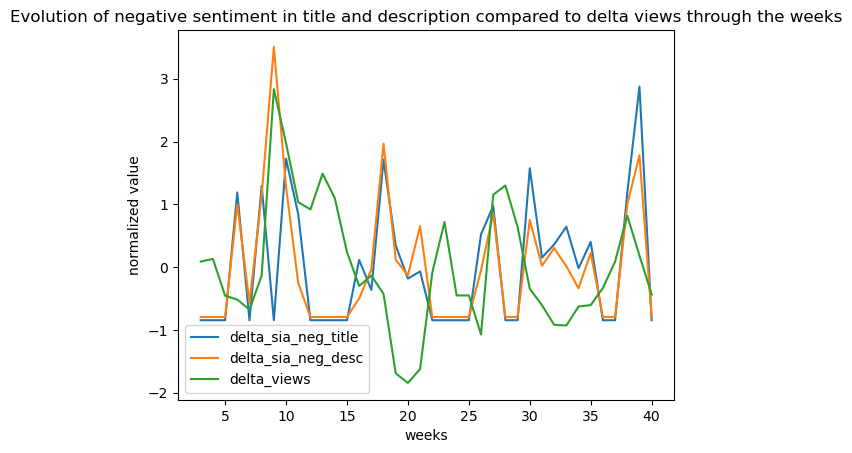

In [36]:
# Negative title, desc compared to views
for chan_id, chan_deltas in sample_channel_deltas:
    print("sample channe is " + chan_id)
    chan_deltas_norm = normalize(chan_deltas)
    chan_deltas_norm.plot(x="week_idx",y=["delta_sia_neg_title","delta_sia_neg_desc","delta_views"], xlabel="weeks",ylabel="normalized value", title="Evolution of negative sentiment in title and description compared to delta views through the weeks")

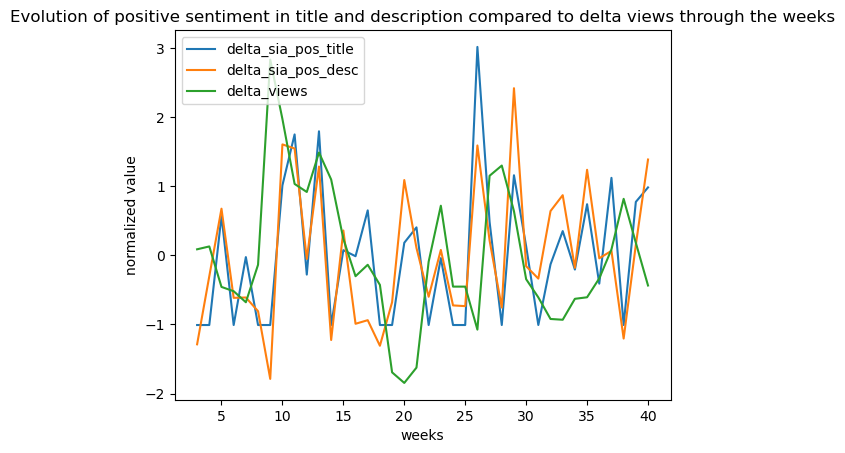

In [37]:
# Positive title, desc compared to views
for chan_id, chan_deltas in sample_channel_deltas:
    chan_deltas_norm = normalize(chan_deltas)
    chan_deltas_norm.plot(x="week_idx",y=["delta_sia_pos_title","delta_sia_pos_desc","delta_views"], xlabel="weeks",ylabel="normalized value", title="Evolution of positive sentiment in title and description compared to delta views through the weeks")

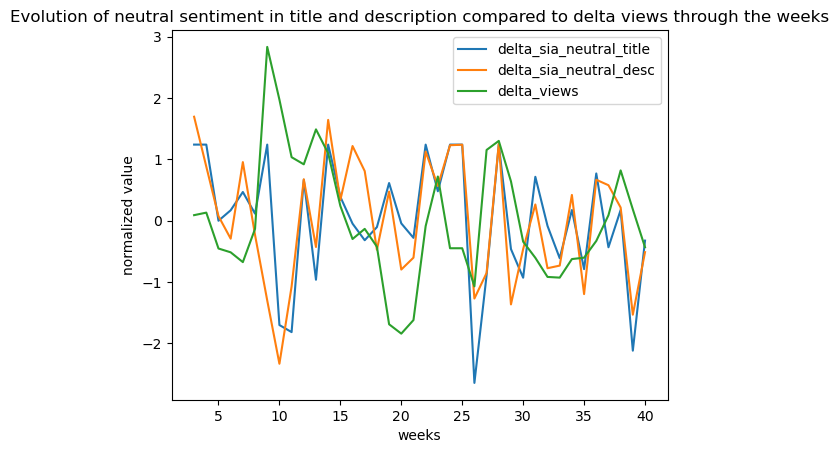

In [38]:
# Neutral title, desc compared to views
for chan_id, chan_deltas in sample_channel_deltas:
    chan_deltas_norm = normalize(chan_deltas)
    chan_deltas_norm.plot(x="week_idx",y=["delta_sia_neutral_title","delta_sia_neutral_desc","delta_views"], xlabel="weeks",ylabel="normalized value", title="Evolution of neutral sentiment in title and description compared to delta views through the weeks")

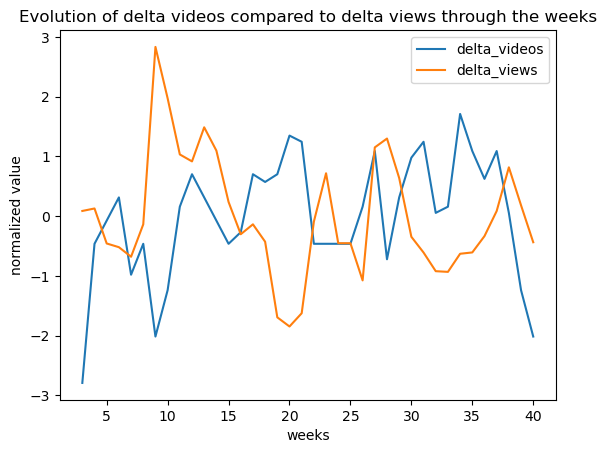

In [39]:
# delta videos compared to views
for chan_id, chan_deltas in sample_channel_deltas:
    chan_deltas_norm = normalize(chan_deltas)
    chan_deltas_norm.plot(x="week_idx",y=["delta_videos","delta_views"], xlabel="weeks",ylabel="normalized value", title="Evolution of delta videos compared to delta views through the weeks")

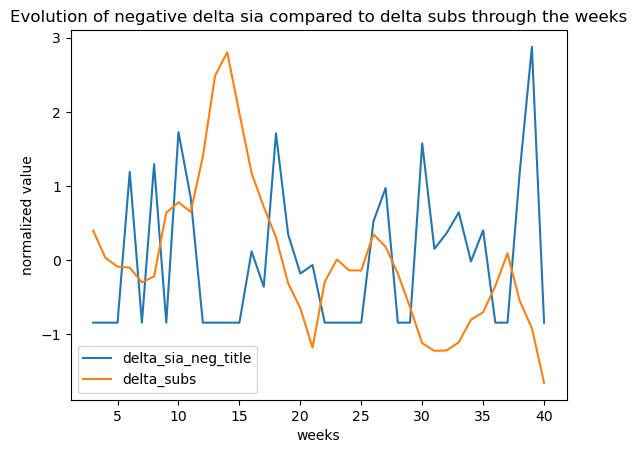

In [40]:
# Negative title compared to delta subs
for chan_id, chan_deltas in sample_channel_deltas:
    chan_deltas_norm = normalize(chan_deltas)
    chan_deltas_norm.plot(x="week_idx",y=["delta_sia_neg_title","delta_subs"], xlabel="weeks",ylabel="normalized value", title="Evolution of negative delta sia compared to delta subs through the weeks")

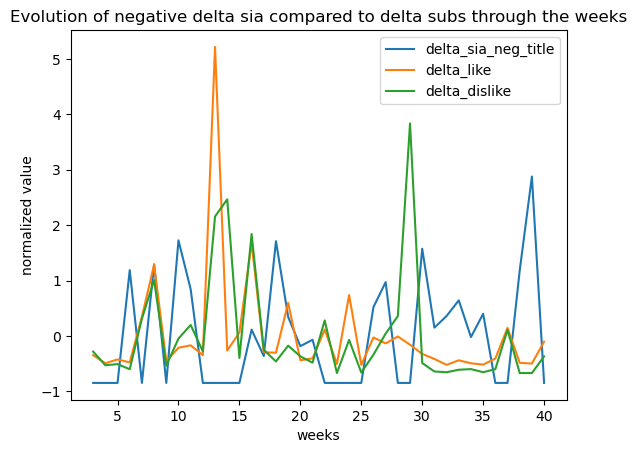

In [41]:
# Negative title compared to delta like, delta dislike
for chan_id, chan_deltas in sample_channel_deltas:
    chan_deltas_norm = normalize(chan_deltas)
    chan_deltas_norm.plot(x="week_idx",y=["delta_sia_neg_title","delta_like","delta_dislike"], xlabel="weeks",ylabel="normalized value", title="Evolution of negative delta sia compared to delta subs through the weeks")